## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)

# Keras 

Keras is a python abstraction which allows you to define a neural network and have it automatically coded for deep learning libraries (currently DeepLearning4j, TensorFlow, and Theano). You just tell Keras how many layers are in the network model and define what those layers look like. Keras handles converting it into something that TensorFlow and Theano can use. So it's great for rapid development experimentation with neural networks. You can quickly build things and quickly tweak neural networks.



In [20]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "floatX=float32,device=cpu,nvcc.flags=-D_FORCE_INLINES"
import numpy as np
import theano as th
import theano.tensor as T
from keras import backend as kBack
kBack.set_image_dim_ordering('th')
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras


# Dataset setup

The data file is in pickled format and the data that was saved contained one large Python dictionary array. The dictionary keys were the combinations of modulation type and signal to noise (SNR) ratios that were simulated by GNU Radio to produce the data

The data format looks like this

 {('mod type', SNR): np.array(nvecs_per_key, 2, vec_length), etc}

Dataset consists of 11 modulations: 8 digital and 3 analog modulation, all are widely used in wireless communications systems all around us.These consist of BPSK,QPSK,8PSK,16QAM,64QAM,BFSK,CPFSK,and PAM4 for digital modulations, and WB-FM, AM-SSB, and AM-DSB for analog modulations. Data is modulated at a rate of roughly 8 samples per symbol with a normalized average transmit power of 0dB

In [21]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding='bytes')

#Calculate signal to noise ratios (SNRS) and modulations (mods)

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [22]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [23]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I (In- phase) component
    Q = s[1,:]   # Q (Quadrature) component
    n = len(I)   # number of samples
    f = 10e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))



Text(0.5,1,'QAM64 @ -12 dB')

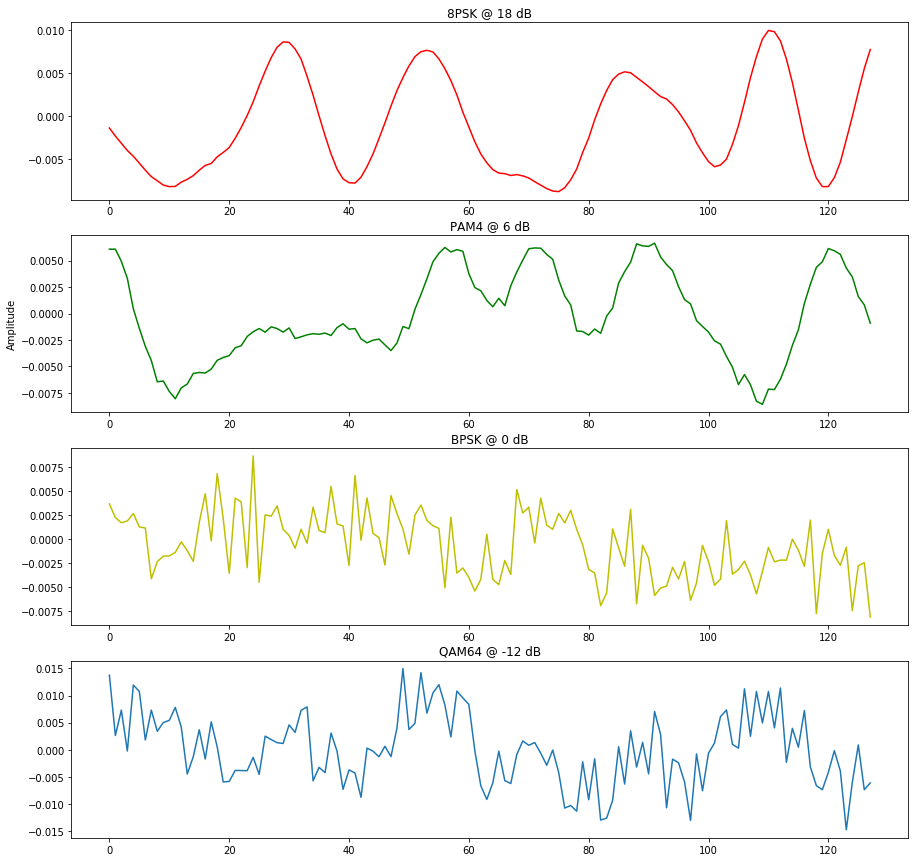

In [24]:
 # To get the feel of actual signal
 # Plot some of the data.
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd[b'8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd[b'PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd[b'BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd[b'QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

In [25]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

print('X_train set is {}'.format(np.shape(X_train)))
print('X_test set is {}'.format(np.shape(X_test)))

print('Y_train set is {}'.format(np.shape(Y_train)))
print('Y_test set is {}'.format(np.shape(Y_test)))

X_train set is (110000, 2, 128)
X_test set is (110000, 2, 128)
Y_train set is (110000, 11)
Y_test set is (110000, 11)


In [26]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


# Technical Approach
In a radio communication system,one class of receiver which is commonly considered is a "matched-ﬁlter" receiver. That is on the receive side of a communications link, expert designed ﬁlters matched with each transmitted symbol representation are convolved with the incoming time signal, and form peaks as the correct symbol slides over the correct symbol time in the received signal. By convolving, we average out the impulsive noise in the receiver in an attempt to optimize signal to noise. Typically, before this convolutional stage, symbol timing and carrier frequency is recovered using an expert envelope or moment based estimators derived analytically for a speciﬁc modulation and channel model. The intuition behind the use of a convolutional neural network in this application then is that they will learn to form matched ﬁlters for numerous temporal features, each of which will have some ﬁlter gain to operate at lower SNR, and which when taken together can form a robust basis for classiﬁcation.

# Build the NN Model

In [27]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu(rectiﬁed linear) layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
model.summary()

C:\Users\homepc\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, name="dense2", kernel_initializer="he_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 1, 132)        0         
__________

In [28]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [29]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
 - 1637s - loss: 2.2543 - acc: 0.1463 - val_loss: 2.1239 - val_acc: 0.1980
Epoch 2/100
 - 1512s - loss: 2.0338 - acc: 0.2518 - val_loss: 1.9203 - val_acc: 0.2836
Epoch 3/100
 - 1555s - loss: 1.9002 - acc: 0.2896 - val_loss: 1.7992 - val_acc: 0.3251
Epoch 4/100
 - 1527s - loss: 1.7970 - acc: 0.3280 - val_loss: 1.6711 - val_acc: 0.3959
Epoch 5/100
 - 1912s - loss: 1.6855 - acc: 0.3711 - val_loss: 1.5733 - val_acc: 0.4189
Epoch 6/100
 - 1552s - loss: 1.6183 - acc: 0.3925 - val_loss: 1.5076 - val_acc: 0.4399
Epoch 7/100
 - 2213s - loss: 1.5720 - acc: 0.4080 - val_loss: 1.4658 - val_acc: 0.4460
Epoch 8/100
 - 1722s - loss: 1.5346 - acc: 0.4189 - val_loss: 1.4285 - val_acc: 0.4640
Epoch 9/100
 - 1677s - loss: 1.4999 - acc: 0.4324 - val_loss: 1.4066 - val_acc: 0.4700
Epoch 10/100
 - 1560s - loss: 1.4733 - acc: 0.4386 - val_loss: 1.3854 - val_acc: 0.4729
Epoch 11/100
 - 1619s - loss: 1.4551 - acc: 0.4445 - val_loss: 1.3522 - val_a

# Evaluate and Plot Model Performance

In [30]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

[1.2826048089027404, 0.4994818181904879]


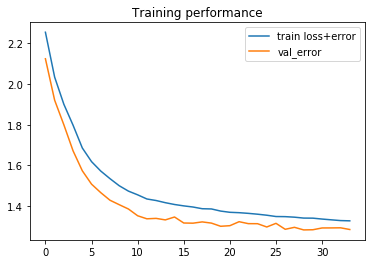

In [31]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [32]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

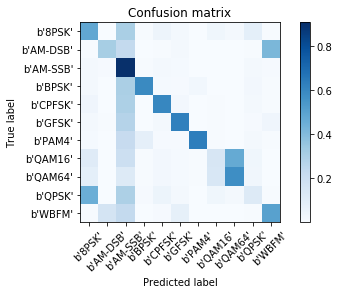

In [33]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.09752973467520586
Overall Accuracy:  0.0893732970027248
Overall Accuracy:  0.0918958031837916
Overall Accuracy:  0.1079032840129917
Overall Accuracy:  0.13345487693710117
Overall Accuracy:  0.2139683668029145
Overall Accuracy:  0.3351093147161492
Overall Accuracy:  0.49230205278592376
Overall Accuracy:  0.6029574861367837
Overall Accuracy:  0.668178519593614
Overall Accuracy:  0.7031021897810219
Overall Accuracy:  0.7030170846964741
Overall Accuracy:  0.7066813509544787
Overall Accuracy:  0.7263537906137184
Overall Accuracy:  0.7137962128043283
Overall Accuracy:  0.7285974499089253
Overall Accuracy:  0.7180879956545356
Overall Accuracy:  0.7329765639416866
Overall Accuracy:  0.712579185520362
Overall Accuracy:  0.7188118811881188


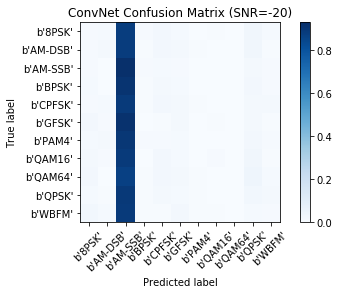

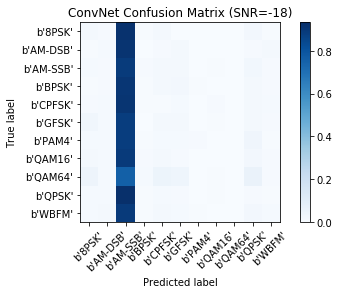

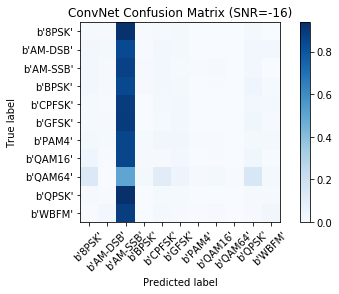

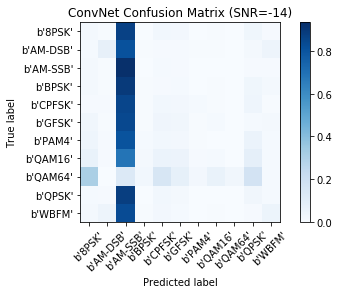

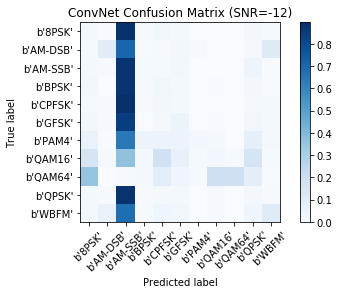

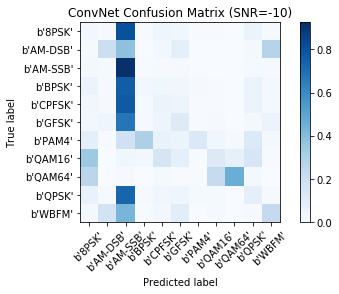

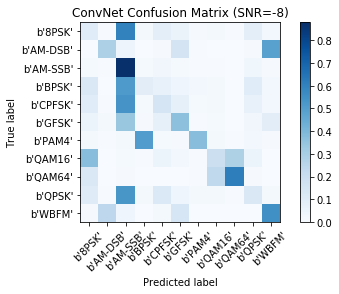

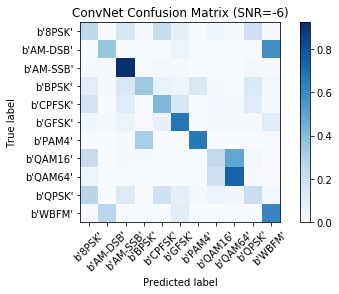

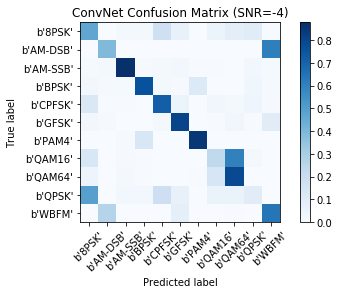

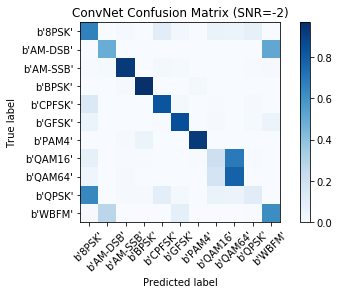

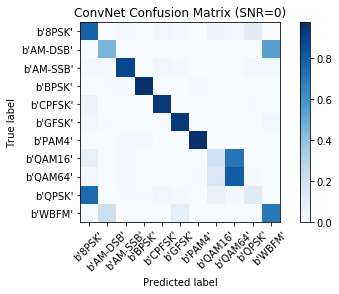

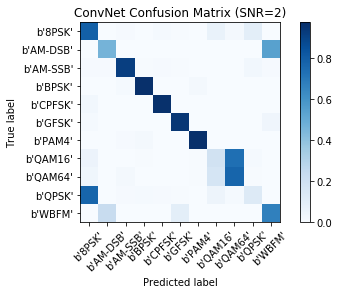

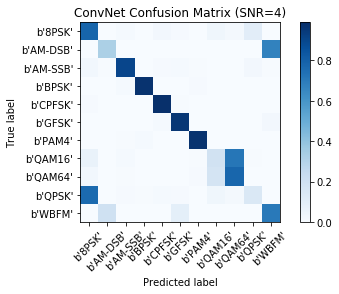

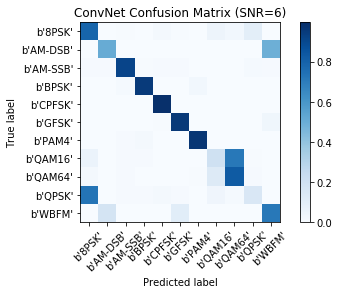

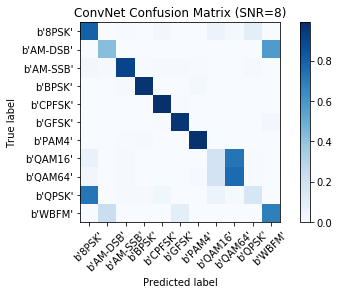

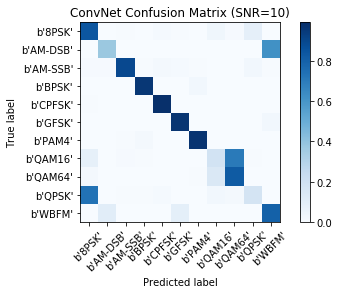

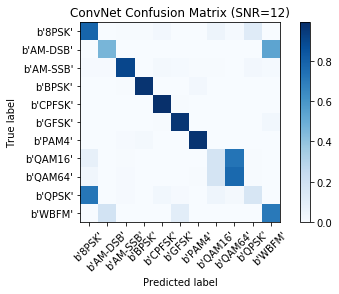

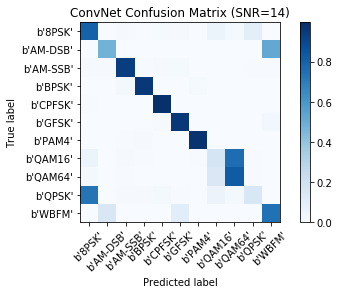

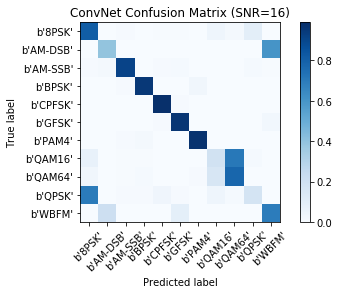

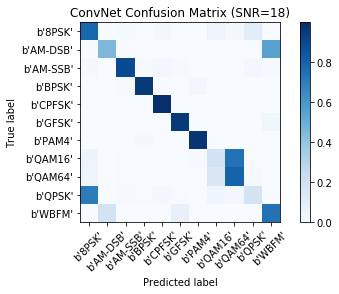

In [91]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
   
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
       
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [92]:
# Save results to a pickle file for plotting later
print (acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.7031021897810219, 16: 0.712579185520362, 2: 0.7030170846964741, 4: 0.7066813509544787, 6: 0.7263537906137184, 8: 0.7137962128043283, 12: 0.7180879956545356, 10: 0.7285974499089253, -20: 0.09752973467520586, 18: 0.7188118811881188, -18: 0.0893732970027248, -16: 0.0918958031837916, -14: 0.1079032840129917, -12: 0.13345487693710117, 14: 0.7329765639416866, -10: 0.2139683668029145, -8: 0.3351093147161492, -6: 0.49230205278592376, -4: 0.6029574861367837, -2: 0.668178519593614}


Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

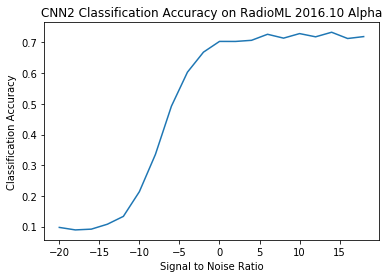

In [94]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")